## Applying the Elo System to D1 NCAA Men's Basketball

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import bs4
import requests
import re
import time as t
from datetime import datetime as dt

### Code to Initialize System

In [ ]:
# This is the code used to initially scrape the historical matchup data
# All of the scraped data is now contained in a csv file
matchup_history = pd.DataFrame(columns=["Date","Team A","Home/Away","Team B","A Pts","B Pts"])
begin = t.time()
for i in range(163600,269708,100):
    print("Percent Complete: {:.2f}".format((i/269708)*100))
    link = "https://www.sports-reference.com/cbb/play-index/matchup_finder.cgi?request=1&year_min=1950&year_max=2023&school_id=&opp_id=&game_type=A&game_month=&game_location=&game_result=W&is_overtime=&comp_school=le&comp_opp=le&rank_school=ANY&rank_opp=ANY&order_by=date_game&order_by_asc=&offset="+str(i) #Create link address
    site = requests.get(link) #Get html code from link
    soup = bs4.BeautifulSoup(site.text,"html.parser") 
    table_html = soup.find(id="stats")
    for row in table_html.tbody.find_all('tr'):
        try:
            columns = row.find_all('td') #https://medium.com/geekculture/web-scraping-tables-in-python-using-beautiful-soup-8bbc31c5803e
            date = columns[0].text.strip()
            team_a = columns[2].text.strip()
            home_away = columns[4].text.strip()
            team_b = columns[5].text.strip()
            a_pts = columns[9].text.strip()
            b_pts = columns[10].text.strip()
            matchup_info = {"Date":date,"Team A":team_a,"Home/Away":home_away,"Team B":team_b,"A Pts":a_pts,"B Pts":b_pts}
            matchup_history = matchup_history.append(matchup_info,ignore_index=True)
        except:
            continue
end = t.time()
print("{:.4f} Minutes".format((end-begin)/60))
print(matchup_history.shape)
matchup_history.head()

In [3]:
# Code used to initialize the elo system, starting from 1950
matchup_data = pd.read_csv("D1 Matchup History.csv",usecols=["Date","Team A","Home/Away","Team B","A Pts","B Pts", "A Elo Pre","B Elo Pre","A Elo Post","B Elo Post"])
d1_teams = pd.read_csv("D1 Teams.csv")
team_conf = dict(d1_teams.values)
current_elos = dict([(team, 1300) for team in team_conf.keys()])
K = 20
last_game = matchup_data["Date"][0] #Initialize date tracking variable
for index, row in matchup_data.iterrows():
    if new_season(last_game, row["Date"]):
        '''Add code to regress every teams elo towards the conference mean at the end of each season'''
        current_elos = conf_elo_regression(current_elos, team_conf)
        print(row["Date"])
    if (row["Team A"] in team_conf) and (row["Team B"] in team_conf):
        #Check that both teams are D1, otherwise skip the matchup
        matchup_data.at[index,"A Elo Pre"] = current_elos[row["Team A"]]
        matchup_data.at[index,"B Elo Pre"] = current_elos[row["Team B"]]
        pr_a = elo_win_prob(matchup_data["A Elo Pre"][index], matchup_data["B Elo Pre"][index])
        if row["A Pts"] > row["B Pts"]:
            result = 1
        else:
            result = 0
        mov_mult = (2.2 * np.log(abs(row["A Pts"]-row["B Pts"])+1)) / (abs(row["A Pts"]-row["B Pts"])*0.001+2.2)
        elo_gain_a = K*(result-pr_a)*mov_mult
        matchup_data.at[index,"A Elo Post"] = matchup_data["A Elo Pre"][index] + elo_gain_a
        matchup_data.at[index,"B Elo Post"] = matchup_data["B Elo Pre"][index] - elo_gain_a
        current_elos[row["Team A"]] = matchup_data["A Elo Post"][index]
        current_elos[row["Team B"]] = matchup_data["B Elo Post"][index]
    last_game = row["Date"]
matchup_data.tail()

1950-11-25
1951-11-26
1952-11-28
1953-11-26
1954-12-01
1955-12-01
1956-11-30
1957-12-02
1958-12-01
1959-12-01
1960-12-01
1961-11-26
1962-11-30
1963-11-30
1964-12-01
1965-12-01
1966-12-01
1967-12-01
1968-11-30
1969-12-01
1970-12-01
1971-12-01
1972-11-24
1973-11-27
1974-11-29
1975-11-28
1976-11-26
1977-11-24
1978-11-18
1979-11-17
1980-11-22
1981-11-21
1982-11-20
1983-11-19
1984-11-18
1985-11-21
1986-11-21
1987-11-20
1988-11-18
1989-11-15
1990-11-14
1991-11-15
1992-11-18
1993-11-17
1994-11-16
1995-11-10
1996-11-15
1997-11-08
1998-11-07
1999-11-11
2000-11-09
2001-11-08
2002-11-14
2003-11-13
2004-11-11
2005-11-08
2006-11-07
2007-11-05
2008-11-10
2009-11-09
2010-11-08
2011-11-07
2012-11-09
2013-11-08
2014-11-14
2015-11-13
2016-11-11
2017-11-10
2018-11-06
2019-11-05
2020-11-25
2021-11-09
2022-11-03


,Unnamed: 0,Date,Team A,Home/Away,Team B,A Pts,B Pts,A Elo Pre,B Elo Pre,A Elo Post,B Elo Post
271001,271001,2022-12-15,Nicholls State,NaN,Southeastern Louisiana,88,73,1086.655418,1021.887711,1109.118636,999.424493
271002,271002,2022-12-15,Southern Indiana,NaN,Saint Mary-of-the-Woods College,84,42,NaN,NaN,NaN,NaN
271003,271003,2022-12-15,Texas-Rio Grande Valley,NaN,NaN,106,80,NaN,NaN,NaN,NaN
271004,271004,2022-12-15,Brigham Young,NaN,Western Oregon,97,64,NaN,NaN,NaN,NaN
271005,271005,2022-12-15,Santa Clara,NaN,UC Irvine,86,74,1479.007188,1365.033482,1496.436852,1347.603818


### Elo System Functions

In [2]:
def elo_win_prob(A_elo, B_elo):
    '''Calculates the probability of Team A winning based on each teams elo rating'''
    elo_diff = A_elo - B_elo
    Prob_a_win = 1 / ((10**(-elo_diff/400))+1)
    return Prob_a_win

def new_season(last_date, current_date):
    '''Checks whether two dates are in a different season'''
    time_1 = dt.strptime(last_date,"%Y-%m-%d")
    time_2 = dt.strptime(current_date,"%Y-%m-%d")
    delta = time_2 - time_1
    if delta.days > 100:
        return True
    else:
        return False

def conf_elo_regression(current_elos, conf_teams):
    '''Regress each teams elo by a third towards their conference average'''
    conf_list = ["America East","American Athletic","Atlantic 10","Atlantic Coast","Atlantic Sun","Big 12","Big East","Big Sky","Big South","Big Ten","Big West","Colonial Athletic Association","Conference USA","Horizon League","Ivy League","Metro Atlantic Athletic","Mid-American","Mid-Eastern Athletic","Missouri Valley","Mountain West","Northeast","Ohio Valley","Pac-12","Patriot League","Southeastern","Southern","Southland","Southwest Athletic","Summit League","Sun Belt","West Coast","Western Athletic"]
    for conference in conf_list:
        conf_team_list = [team for team, conf in conf_teams.items() if conf == conference]
        elo_avg = sum([current_elos[team] for team in conf_team_list])/len(conf_team_list)
        for team in conf_team_list:
            current_elos[team] = (2*current_elos[team]/3) + (elo_avg/3) 
    return current_elos

def update_matchup_history(matchup_history):
    '''Update matchup_history dataframe to the current day'''
    link = "https://www.sports-reference.com/cbb/play-index/matchup_finder.cgi?request=1&year_min=1950&year_max=2023&comp_school=le&rank_school=ANY&comp_opp=le&rank_opp=ANY&game_type=A&game_result=W&order_by=date_game&order_by_asc=Y"
    site = requests.get(link) #Get html code from link
    soup = bs4.BeautifulSoup(site.text,"html.parser")
    game_string = soup.find_all(string=re.compile("Wins"),limit=1)[0]
    games = str(game_string).split()[0]
    for i in range(matchup_history.shape[0],int(games),100):
        print("Percent Complete: {:.2f}".format((i/int(games))*100))
        link = "https://www.sports-reference.com/cbb/play-index/matchup_finder.cgi?request=1&year_min=1950&year_max=2023&school_id=&opp_id=&game_type=A&game_month=&game_location=&game_result=W&is_overtime=&comp_school=le&comp_opp=le&rank_school=ANY&rank_opp=ANY&order_by=date_game&order_by_asc=Y&offset="+str(i) #Create link address
        site = requests.get(link) #Get html code from link
        soup = bs4.BeautifulSoup(site.text,"html.parser") 
        table_html = soup.find(id="stats")
        for row in table_html.tbody.find_all('tr'):
            try:
                columns = row.find_all('td') #https://medium.com/geekculture/web-scraping-tables-in-python-using-beautiful-soup-8bbc31c5803e
                date = columns[0].text.strip()
                team_a = columns[2].text.strip()
                home_away = columns[4].text.strip()
                team_b = columns[5].text.strip()
                a_pts = columns[9].text.strip()
                b_pts = columns[10].text.strip()
                matchup_info = {"Date":date,"Team A":team_a,"Home/Away":home_away,"Team B":team_b,"A Pts":a_pts,"B Pts":b_pts}
                matchup_history = matchup_history.append(matchup_info,ignore_index=True)
            except:
                continue
    return matchup_history

def update_elo_rankings(matchup_history, team_conf, current_elos):
    '''Update the elo ranking of every team based on games since last update'''
    index_start = matchup_history.shape[0]
    matchup_data = update_matchup_history(matchup_history)
    for i in range(index_start,matchup_data.shape[0]):
        row = matchup_data.iloc[i]
        if (row["Team A"] in team_conf) and (row["Team B"] in team_conf):
            #Check that both teams are D1, otherwise skip the matchup
            matchup_data.at[i,"A Elo Pre"] = current_elos[row["Team A"]]
            matchup_data.at[i,"B Elo Pre"] = current_elos[row["Team B"]]
            pr_a = elo_win_prob(matchup_data["A Elo Pre"][i], matchup_data["B Elo Pre"][i])
            if row["A Pts"] > row["B Pts"]:
                result = 1
            else:
                result = 0
            mov_mult = (2.2 * np.log(abs(row["A Pts"]-row["B Pts"])+1)) / (abs(row["A Pts"]-row["B Pts"])*0.001+2.2)
            elo_gain_a = K*(result-pr_a)*mov_mult
            matchup_data.at[i,"A Elo Post"] = matchup_data["A Elo Pre"][i] + elo_gain_a
            matchup_data.at[i,"B Elo Post"] = matchup_data["B Elo Pre"][i] - elo_gain_a
            current_elos[row["Team A"]] = matchup_data["A Elo Post"][i]
            current_elos[row["Team B"]] = matchup_data["B Elo Post"][i]
    return matchup_data, current_elos

In [ ]:
matchup_history = pd.read_csv("D1 Matchup History.csv",usecols=["Date","Team A","Home/Away","Team B","A Pts","B Pts", "A Elo Pre","B Elo Pre","A Elo Post","B Elo Post"])
matchup_data, current_elos = update_elo_rankings(matchup_history, team_conf, current_elos)
matchup_data.tail()

## Analysis

Elo Max: 1924
Elo Min: 680


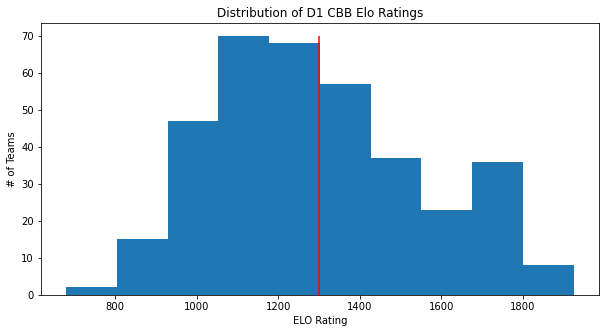

In [25]:
plt.figure(figsize=(10,5))
plt.hist(current_elos.values())
plt.vlines(sum(current_elos.values())/len(current_elos.values()), 0,70,"r", label="Mean")
plt.xlabel("ELO Rating")
plt.ylabel("# of Teams")
plt.title("Distribution of D1 CBB Elo Ratings")
print("Elo Max: {:.0f}".format(max(current_elos.values())))
print("Elo Min: {:.0f}".format(min(current_elos.values())))

As the Elo system is a zero-sum system with all team Elo ratings initialized at 1300, the average Elo rating of all teams is 1300. The majority of teams fall within 500 elo points of the mean (800, 1800), with the highest current Elo rating at 1924 and the lowest current rating at 680. 

In [32]:
power_five = ["Atlantic Coast","Big Ten","Big 12","Pac-12","Southeastern"]
mid_majors = ["America East","American Athletic","Atlantic 10","Atlantic Sun","Big East","Big Sky","Big South","Big West","Colonial Athletic Association","Conference USA","Horizon League","Ivy League","Metro Atlantic Athletic","Mid-American","Mid-Eastern Athletic","Missouri Valley","Mountain West","Northeast","Ohio Valley","Patriot League","Southern","Southland","Southwest Athletic","Summit League","Sun Belt","West Coast","Western Athletic"]
print("Average Elo Ratings of Power Five Conferences:")
for conference in power_five:
    conf_team_list = [team for team, conf in team_conf.items() if conf == conference]
    elo_avg = sum([current_elos[team] for team in conf_team_list])/len(conf_team_list)
    print("{}: {:.0f}".format(conference,elo_avg))
print("Average Elo Ratings of Mid-Major Conferences")
for conference in mid_majors:
    conf_team_list = [team for team, conf in team_conf.items() if conf == conference]
    elo_avg = sum([current_elos[team] for team in conf_team_list])/len(conf_team_list)
    print("{}: {:.0f}".format(conference,elo_avg))

Average Elo Ratings of Power Five Conferences:
Atlantic Coast: 1608
Big Ten: 1705
Big 12: 1757
Pac-12: 1563
Southeastern: 1671
Average Elo Ratings of Mid-Major Conferences
America East: 1088
American Athletic: 1514
Atlantic 10: 1418
Atlantic Sun: 1151
Big East: 1667
Big Sky: 1173
Big South: 1066
Big West: 1209
Colonial Athletic Association: 1236
Conference USA: 1342
Horizon League: 1160
Ivy League: 1243
Metro Atlantic Athletic: 1190
Mid-American: 1252
Mid-Eastern Athletic: 916
Missouri Valley: 1316
Mountain West: 1489
Northeast: 1011
Ohio Valley: 1133
Patriot League: 1130
Southern: 1189
Southland: 977
Southwest Athletic: 935
Summit League: 1166
Sun Belt: 1201
West Coast: 1421
Western Athletic: 1266
